In [12]:
# 读取数据
import time
import pandas as pd #数据分析
import matplotlib.pyplot as plt
import numpy as np
time_start=time.time()
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)

#去重
# import matplotlib.pyplot as plt
# IsDuplicated=data.duplicated()
#
# IsDuplicated.value_counts().plot(kind='bar')
# plt.show()
data_1=data.drop_duplicates()

#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
# dummies_service = pd.get_dummies(data_1["service"], prefix='service')
# data_2 = pd.concat([data_1, dummies_protocol,dummies_flag,dummies_service], axis=1)
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
feature_selection=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_access_files",
    "num_outbound_cmds","is_guest_login","rerror_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR",
    "flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_3=data_2[feature_selection]
y_3=data_2['label'].copy()   #一维

# feature_selection=["duration","src_bytes",
#     "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
#     "logged_in","num_compromised","root_shell","su_attempted","num_root",
#     "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
#     "is_host_login","is_guest_login","count","srv_count","serror_rate",
#     "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
#     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
#     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
#     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
#     "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
# X_3=data_1[feature_selection]
# y_3=data_1['label'].copy()   #一维

##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop."]
probe=["satan.","portsweep.","ipsweep.","nmap."]
for i in u2r:
    y_3[y_3==i]="u2r"
for i in r2l:
    y_3[y_3==i]="r2l"
for i in dos:
    y_3[y_3==i]="dos"
for i in probe:
    y_3[y_3==i]="probe"
y_3[y_3=="normal."]="normal"
y_3=np.array(y_3)  #变成array格式，一维
#混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
#过采样 smote
from imblearn.over_sampling import SMOTE
oversampler=SMOTE(random_state=42)
X_smote,y=oversampler.fit_sample(X_3,y_3)
#标准化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X_smote)
X=scaler.transform(X_smote)  #X是ndarray
#分类器
from sklearn.ensemble import RandomForestClassifier
##建立模型
clf_1 = RandomForestClassifier()
#验证测试样本
# from sklearn.model_selection import train_test_split
# X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X,y,test_size=0.2,random_state=0)  #切分样本
# clf_1.fit(X_train_1,y_train_1)
clf_1.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
# 读取数据
import time
import pandas as pd #数据分析
import matplotlib.pyplot as plt
import numpy as np
time_start=time.time()
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data_test= pd.read_csv("E:\Pycharm\Intrusion_Detection\corrected.csv",  header=None,names = col_names)

#去重
# import matplotlib.pyplot as plt
# IsDuplicated=data.duplicated()
#
# IsDuplicated.value_counts().plot(kind='bar')
# plt.show()
data_test_1=data_test.drop_duplicates()

#one-hot
dummies_protocol = pd.get_dummies(data_test_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_test_1["flag"], prefix='flag')
# dummies_service = pd.get_dummies(data_1["service"], prefix='service')
# data_2 = pd.concat([data_1, dummies_protocol,dummies_flag,dummies_service], axis=1)
data_test_2 = pd.concat([data_test_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
feature_selection=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_access_files",
    "num_outbound_cmds","is_guest_login","rerror_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR",
    "flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_test_3=data_test_2[feature_selection]
y_test=data_test_2['label'].copy()   #一维

# feature_selection=["duration","src_bytes",
#     "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
#     "logged_in","num_compromised","root_shell","su_attempted","num_root",
#     "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
#     "is_host_login","is_guest_login","count","srv_count","serror_rate",
#     "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
#     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
#     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
#     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
#     "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
# X_3=data_1[feature_selection]
# y_3=data_1['label'].copy()   #一维

##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit.","httptunnel.","ps.","sqlattack.","xterm."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient.","named.","sendmail."
    ,"snmpgetattack.","snmpguess.","worm.","xlock.","xsnoop."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop.","apache2.","mailbomb.","processtable.","udpstorm."]
probe=["satan.","portsweep.","ipsweep.","nmap.","mscan.","saint."]
for i in u2r:
    y_test[y_test==i]="u2r"
for i in r2l:
    y_test[y_test==i]="r2l"
for i in dos:
    y_test[y_test==i]="dos"
for i in probe:
    y_test[y_test==i]="probe"
y_test[y_test=="normal."]="normal"
y_test=np.array(y_test)  #变成array格式，一维

#标准化
X_test=scaler.transform(X_test_3)  #X是ndarray

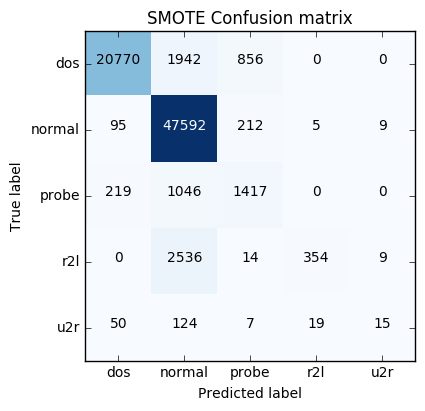

 SMOTE


             precision    recall  f1-score   support

        dos   0.982777  0.881280  0.929265     23568
     normal   0.893914  0.993300  0.940990     47913
      probe   0.565443  0.528337  0.546261      2682
        r2l   0.936508  0.121524  0.215132      2913
        u2r   0.454545  0.069767  0.120968       215

avg / total   0.909996  0.907583  0.894080     77291

--------------------------------------------------------------------------------


In [15]:
#Predition
preditions=clf_1.predict(X_test)
#混淆矩阵
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,preditions)
class_names=['dos','normal','probe','r2l','u2r']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='SMOTE Confusion matrix')
plt.show()
#分类报告
from sklearn.metrics import classification_report
class_names=['dos','normal','probe','r2l','u2r']
print(" SMOTE")
print(classification_report(y_test,preditions,target_names=class_names,digits=6))
print("--------------------------------------------------------------------------------")

928.2220928668976 s


 Baseline


C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        DOS   0.000000  0.000000  0.000000    229853
     Normal   0.194815  1.000000  0.326100     60593
    Probing   0.000000  0.000000  0.000000      4166
        R2L   0.000000  0.000000  0.000000     16189
        U2R   0.000000  0.000000  0.000000       228

avg / total   0.037953  0.194815  0.063529    311029

--------------------------------------------------------------------------------
 SMOTE+ENN


             precision    recall  f1-score   support

        DOS   0.990946  0.004285  0.008534    229853
     Normal   0.195423  0.994933  0.326680     60593
    Probing   0.000000  0.000000  0.000000      4166
        R2L   0.383464  0.036383  0.066460     16189
        U2R   0.222222  0.008772  0.016878       228

avg / total   0.790510  0.198895  0.073420    311029

--------------------------------------------------------------------------------


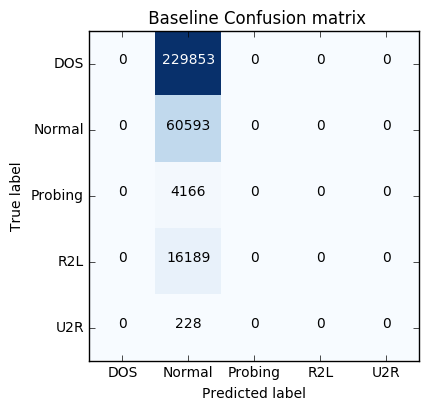

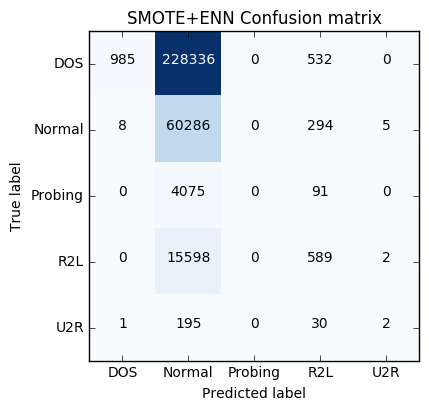

In [16]:
# 读取数据
import time
import pandas as pd #数据分析
import matplotlib.pyplot as plt
import numpy as np
#混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
time_start=time.time()
#读取training data
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)

#去重
data_1=data.drop_duplicates()

#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
feature_selection=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_access_files",
    "num_outbound_cmds","is_guest_login","rerror_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR",
    "flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_3=data_2[feature_selection]
y_3=data_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop."]
probe=["satan.","portsweep.","ipsweep.","nmap."]
for i in u2r:
    y_3[y_3==i]='U2R' #u2r
for i in r2l:
    y_3[y_3==i]='R2L' #r2l
for i in dos:
    y_3[y_3==i]='DOS'  #dos
for i in probe:
    y_3[y_3==i]='Probing' #probe
y_3[y_3=="normal."]='Normal' #normal
y_3=np.array(y_3)  #变成array格式，一维

#读取test data
data_test= pd.read_csv("E:\Pycharm\Intrusion_Detection\corrected.csv",  header=None,names = col_names)
#one-hot
dummies_protocol = pd.get_dummies(data_test["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_test["flag"], prefix='flag')
data_test_2 = pd.concat([data_test, dummies_protocol,dummies_flag], axis=1)
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
X_test=data_test_2[feature_selection]
y_test=data_test_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit.","httptunnel.","ps.","sqlattack.","xterm."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient.","named.","sendmail."
    ,"snmpgetattack.","snmpguess.","worm.","xlock.","xsnoop."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop.","apache2.","mailbomb.","processtable.","udpstorm."]
probe=["satan.","portsweep.","ipsweep.","nmap.","mscan.","saint."]
for i in u2r:
    y_test[y_test==i]="U2R"
for i in r2l:
    y_test[y_test==i]="R2L"
for i in dos:
    y_test[y_test==i]="DOS"
for i in probe:
    y_test[y_test==i]="Probing"
y_test[y_test=="normal."]="Normal"
y_test=np.array(y_test)  #变成array格式，一维


#baseline
#标准化
from sklearn.preprocessing import StandardScaler
scaler_base=StandardScaler().fit(X_3)
X_b=scaler_base.transform(X_3)  #X是ndarray，二维

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test=train_test_split(X_b,y_3,test_size=0.2,random_state=0)  #切分样本
# #可视化
# y_b=pd.DataFrame(y_3,columns=['label'])
# plt.figure()
# plt.title("Baseline")
# y_b['label'].value_counts().plot(kind='bar',rot=45)
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2).fit_transform(X_test)
# classes=['Normal','Probing','DOS','U2R','R2L']
# colors=['blue','red','y','m','w']
# plt.figure()
# plt.title("Baseline")
#
# for index,label,color in zip(range(len(classes)),classes,colors):
#     plt.scatter(X_embedded[y_test==label,0],
#                 X_embedded[y_test==label,1],
#                 label=classes[index],
#                 c=color)
# plt.legend(loc='best')
#
# # plt.show()
#分类器
from sklearn.ensemble import RandomForestClassifier
##建立模型
clf_1 = RandomForestClassifier(n_estimators=100)
#
# #学习曲线
# import numpy as np
# from sklearn.model_selection import learning_curve
# train_sizes,train_scores,test_scores=learning_curve(estimator=clf_1,
#                                 X=X_train,y=y_train,
#                                 train_sizes=np.linspace(0.05,1,10),
#                                  cv=10, n_jobs=1,random_state=0)
# train_mean=np.mean(train_scores,axis=1)
# test_mean=np.mean(test_scores,axis=1)
# train_std=np.std(train_scores,axis=1)
# test_std=np.std(train_scores,axis=1)

#验证测试样本
clf_1.fit(X_b,y_3)
preditions_base=clf_1.predict(X_test)

# ###################################################################
# #过采样 smote
# from imblearn.over_sampling import SMOTE
# oversampler=SMOTE(random_state=42)
# X_smote,y_s=oversampler.fit_sample(X_3,y_3)
# #标准化
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler().fit(X_smote)
# X_s=scaler.transform(X_smote)  #X是ndarray
# # #可视化
# # y_smote=pd.DataFrame(y_s,columns=['label'])
# # from sklearn.model_selection import train_test_split
# # X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_s,y_s,test_size=0.2,random_state=0)  #切分样本
# # plt.figure()
# # plt.title("SMOTE")
# # y_smote['label'].value_counts().plot(kind='bar',rot=45)
# # from sklearn.manifold import TSNE
# # X_embedded = TSNE(n_components=2).fit_transform(X_test_1)
# # plt.figure()
# # plt.title("SMOTE")
# # for index,label,color in zip(range(len(classes)),classes,colors):
# #     plt.scatter(X_embedded[y_test_1==label,0],
# #                 X_embedded[y_test_1==label,1],
# #                 label=classes[index],
# #                 c=color)
# # plt.legend(loc='best')
# # # plt.show()
#
# #分类器
# from sklearn.ensemble import RandomForestClassifier
# ##建立模型
# clf_2 = RandomForestClassifier(n_estimators=100)
# #验证测试样本
# clf_2.fit(X_s,y_s)
# preditions_smote=clf_2.predict(X_test)
# # #学习曲线
# # import numpy as np
# # from sklearn.model_selection import learning_curve
# # train_sizes,train_scores,test_scores=learning_curve(estimator=clf_2,
# #                                 X=X_train_1,y=y_train_1,
# #                                 train_sizes=np.linspace(0.05,1,10),
# #                                  cv=10, n_jobs=1,random_state=0)
# # train_mean_1=np.mean(train_scores,axis=1)
# # test_mean_1=np.mean(test_scores,axis=1)
# # train_std_1=np.std(train_scores,axis=1)
# # test_std_1=np.std(train_scores,axis=1)
# #########################################################################
# #欠采样 ENN
# from imblearn.under_sampling import EditedNearestNeighbours
# oversampler=EditedNearestNeighbours(random_state=42,n_neighbors=30)
# X_enn,y_e=oversampler.fit_sample(X_3,y_3)
# #标准化
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler().fit(X_enn)
# X_e=scaler.transform(X_enn)
# #可视化
# y_enn=pd.DataFrame(y_e,columns=['label'])
# plt.figure()
# plt.title("ENN")
# y_enn['lable'].value_counts().plot(kind='bar',rot=45)
# from sklearn.model_selection import train_test_split
# X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(X_e,y_e,test_size=0.2,random_state=0)  #切分样本
#
#
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2).fit_transform(X_test_2)
# plt.figure()
# plt.title("ENN")
# for index,label,color in zip(range(len(classes)),classes,colors):
#     plt.scatter(X_embedded[y_test_2==label,0],
#                 X_embedded[y_test_2==label,1],
#                 label=classes[index],
#                 c=color)
# plt.legend(loc='best')
# # plt.show()
# ##建立模型
# clf_3 = RandomForestClassifier(n_estimators=100)
# #验证测试样本
# clf_3.fit(X_train_2,y_train_2)
# preditions_enn=clf_3.predict(X_test_2)
# #学习曲线
# import numpy as np
# from sklearn.model_selection import learning_curve
# train_sizes,train_scores,test_scores=learning_curve(estimator=clf_3,
#                                 X=X_train_2,y=y_train_2,
#                                 train_sizes=np.linspace(0.05,1,10),
#                                  cv=10, n_jobs=1,random_state=0)
# train_mean_2=np.mean(train_scores,axis=1)
# test_mean_2=np.mean(test_scores,axis=1)
# train_std_2=np.std(train_scores,axis=1)
# test_std_2=np.std(train_scores,axis=1)

##############################################################################
#过采样+欠采样 smote+enn
from imblearn.combine import SMOTEENN
oversampler=SMOTEENN(random_state=42,n_neighbors=100)
X_SMOTEENN,y_se=oversampler.fit_sample(X_3,y_3)
#标准化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X_SMOTEENN)
X_se=scaler.transform(X_SMOTEENN)  #X是ndarray
# #可视化
# y_smoteenn=pd.DataFrame(y_se,columns=['label'])
# plt.figure()
# plt.title("SMOTE+ENN")
# y_smoteenn['label'].value_counts().plot(kind='bar',rot=45)
# from sklearn.model_selection import train_test_split
# X_train_3,X_test_3,y_train_3,y_test_3=train_test_split(X_se,y_se,test_size=0.2,random_state=0)  #切分样本
#
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2).fit_transform(X_test_3)
# plt.figure()
# plt.title("SMOTE+ENN")
# for index,label,color in zip(range(len(classes)),classes,colors):
#     plt.scatter(X_embedded[y_test_3==label,0],
#                 X_embedded[y_test_3==label,1],
#                 label=classes[index],
#                 c=color)
# plt.legend(loc='best')
# # plt.show()
##建立模型
clf_4 = RandomForestClassifier(n_estimators=100)
#验证测试样本
clf_4.fit(X_se,y_se)
preditions_smoteenn=clf_4.predict(X_test)
# #学习曲线
# import numpy as np
# from sklearn.model_selection import learning_curve
# train_sizes,train_scores,test_scores=learning_curve(estimator=clf_4,
#                                 X=X_train_3,y=y_train_3,
#                                 train_sizes=np.linspace(0.05,1,10),
#                                  cv=10, n_jobs=1,random_state=0)
# train_mean_3=np.mean(train_scores,axis=1)
# test_mean_3=np.mean(test_scores,axis=1)
# train_std_3=np.std(train_scores,axis=1)
# test_std_3=np.std(train_scores,axis=1)

time_end=time.time()
print(time_end-time_start,'s')

###########################################################################
#混淆矩阵
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test,preditions_base)
# cnf_matrix_smote=confusion_matrix(y_test_1,preditions_smote)
# cnf_matrix_enn=confusion_matrix(y_test_2,preditions_enn)
cnf_matrix_smoteenn=confusion_matrix(y_test,preditions_smoteenn)
class_names=['DOS','Normal','Probing','R2L','U2R']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title=' Baseline Confusion matrix')
# plt.figure()
# plot_confusion_matrix(cnf_matrix_smote,classes=class_names,title='SMOTE Confusion matrix')
# plt.figure()
# plot_confusion_matrix(cnf_matrix_enn,classes=class_names,title='ENN Confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix_smoteenn,classes=class_names,title='SMOTE+ENN Confusion matrix')
#分类报告
from sklearn.metrics import classification_report
class_names=['DOS','Normal','Probing','R2L','U2R']
print(" Baseline")
# print(test_mean)
print(classification_report(y_test,preditions_base,target_names=class_names,digits=6))
print("--------------------------------------------------------------------------------")
# print(" SMOTE")
# # print(test_mean_1)
# print(classification_report(y_test_1,preditions_smote,target_names=class_names,digits=6))
# print("--------------------------------------------------------------------------------")
# print("ENN")
# # print(test_mean_2)
# print(classification_report(y_test_2,preditions_enn,target_names=class_names,digits=6))
# print("--------------------------------------------------------------------------------")
print(" SMOTE+ENN")
# print(test_mean_3)
print(classification_report(y_test,preditions_smoteenn,target_names=class_names,digits=6))
print("--------------------------------------------------------------------------------")
###########################################################################
# #三种采样的比较
# plt.figure()
#
# plt.grid()
# plt.plot(train_sizes,test_mean,color='b',linestyle='--',
#          marker='p',markersize=5,
#          label=' Baseline validation accuracy')
# plt.plot(train_sizes,test_mean_1,color='k',linestyle='--',
#          marker='+',markersize=5,
#          label='SMOTE validation accuracy')
# plt.plot(train_sizes,test_mean_2,color='y',linestyle='--',
#          marker='*',markersize=5,
#          label=' ENN validation accuracy')
# plt.plot(train_sizes,test_mean_3,color='m',linestyle='--',
#          marker='o',markersize=5,
#          label=' SMOTE+ENN validation accuracy')
# plt.xlabel('Number of training samples')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
plt.show()